In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import argparse
import time
import torch
import torch.nn as nn
import torch.nn.parallel

import torch.utils.data
import matplotlib.pyplot as plt
import warnings 

from torchvision import datasets, transforms
from model.model_architectures import construct_model
from utils.reconstructed import convert_relu_to_sigmoid
from utils.config import config
from model.generator import trainer
warnings.filterwarnings("ignore")


In [2]:
######## Use the Complete ImageNet ########
# dataset = datasets.ImageNet(
#         root='../Datasets/ImageNet', download=False,
#         transform=transforms.Compose([
#             transforms.ToTensor(),
#         ]))

####### Test on the sample images from ImageNet ########
saved_data = torch.load("data/data_sample100_resolution256.pt")[:8]
saved_label = torch.load("data/label_sample100_resolution256.pt")[:8]
from torch.utils.data import Dataset

class CustomImageNet(Dataset):
    def __init__(self, saved_data, saved_label):
        self.data = saved_data
        self.label = saved_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]
        return image, label
    
ImageNetSample = CustomImageNet(saved_data=saved_data, saved_label=saved_label)

In [3]:
# Initialize the manual seed and model
# arch = 'ResNet18'
# model, _ = construct_model(arch, seed=42, num_classes=1000, num_channels=3)

from torchvision.models import resnet18
model = resnet18()
model = model.to(config['device'])
convert_relu_to_sigmoid(model)

In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sigmoid()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sigmoid()
      (conv2): Conv2d(64, 64,

In [5]:
size_batch = 4
config["nz"] = 128
config['total_img'] = size_batch
config['b_size'] = size_batch
config['num_epochs'] = 30000
config["dst"] = "imagenet"

attack =  {'method':'CI-Net','lr':0.001}
config['lr']=attack['lr']
trainer = trainer(config,attack,model,dataset=ImageNetSample)        

reconstructed_image,avg_score = trainer.attack_training()

-----------------ATTACK BEGIN----------------
Configuration Parameters : {'workers': 2, 'b_size': 4, 'num_epochs': 30000, 'lr': 0.001, 'tv_value': 0.0, 'beta1': 0.5, 'ngpu': 1, 'device': device(type='cuda', index=0), 'dst': 'imagenet', 'lr_decay': False, 'signed': True, 'saved_location': './Results', 'classes': 10, 'nc': 3, 'nz': 128, 'ngf': 64, 'noise_setting': 'once', 'rep_freq': 10, 'total_img': 4, 'data_shape': torch.Size([4, 3, 256, 256])}
The channel number is 128
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
It

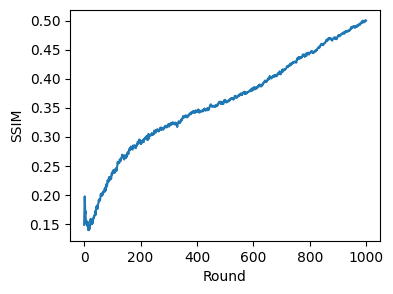

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(avg_score["0"]['CI-Net']['ssim']['score'])
plt.ylabel("SSIM")
plt.xlabel("Round")
plt.show()

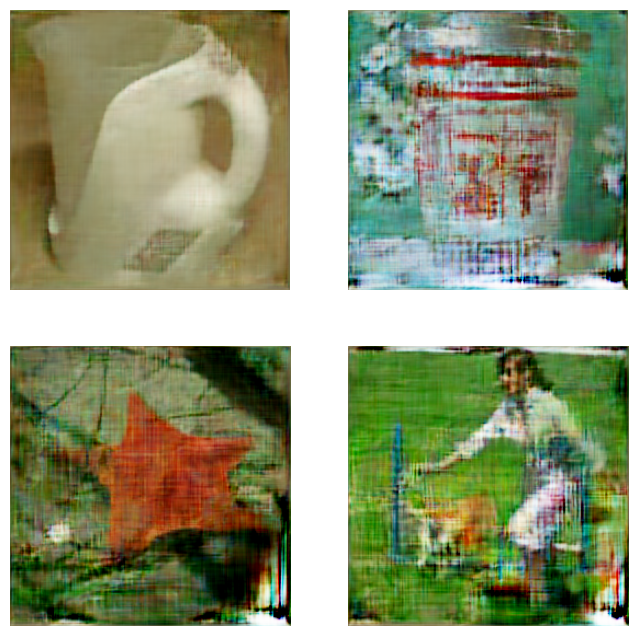

In [ ]:
# Obtained Images
import numpy as np
horizontal = int(np.sqrt(size_batch))
vertical = int(np.sqrt(size_batch))
fig, axes = plt.subplots(horizontal, vertical, figsize=(8,8))
for i in range(horizontal):
    for j in range(vertical):
        axes[i,j].imshow(torch.clamp(reconstructed_image["0"]["image"]['CI-Net']['ssim']["timeline"][0][-1][horizontal*i+j],min = 0 ,max =1)\
                         .detach().cpu().permute(1,2,0))
        axes[i,j].axis('off')
plt.show()